# Setup

In [3]:
# The usuals
import numpy as np
from numpy import quantile, where, random

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import multiprocessing

# Scientific
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string

from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor

from scipy.spatial.distance import cosine

# Supporting

from tqdm import tqdm

from os import listdir
from os.path import isfile, join

from collections import Counter

In [4]:
# Paths
DATA_PATH = '../data/'
OUTPUT = '../output_data/'

In [5]:
# Check files in data folder
datafiles = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
print(datafiles)

['arxiv_disinformation.jsonl', 'arxiv_disinformation.csv']


In [6]:
# Get a file name, can use
filename = datafiles[1]
filename

'arxiv_disinformation.csv'

In [7]:
# Load dataframe
CONVERTERS = {'tokens': eval, 'pos_tokens': eval}

df = pd.read_csv(DATA_PATH + filename, converters=CONVERTERS)

In [8]:
# Check data frame
df.head(3)

,id,guidislink,link,updated,updated_parsed,published,published_parsed,title,title_detail,summary,...,author_detail,author,links,arxiv_primary_category,tags,arxiv_comment,arxiv_doi,arxiv_journal_ref,arxiv_affiliation,tokens
0,http://arxiv.org/abs/2203.05386v1,True,http://arxiv.org/abs/2203.05386v1,2022-03-10T14:24:19Z,"[2022, 3, 10, 14, 24, 19, 3, 69, 0]",2022-03-10T14:24:19Z,"[2022, 3, 10, 14, 24, 19, 3, 69, 0]",Faking Fake News for Real Fake News Detection:...,"{'type': 'text/plain', 'language': None, 'base...",While there has been a lot of research and man...,...,{'name': 'Heng Ji'},Heng Ji,"[{'href': 'http://arxiv.org/abs/2203.05386v1',...","{'term': 'cs.CL', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",NaN,NaN,NaN,NaN,"[lot, research, many, recent, advance, neural,..."
1,http://arxiv.org/abs/2203.05966v1,True,http://arxiv.org/abs/2203.05966v1,2022-03-09T22:42:29Z,"[2022, 3, 9, 22, 42, 29, 2, 68, 0]",2022-03-09T22:42:29Z,"[2022, 3, 9, 22, 42, 29, 2, 68, 0]",Online User Profiling to Detect Social Bots on...,"{'type': 'text/plain', 'language': None, 'base...",Social media platforms can expose influential ...,...,{'name': 'Ozlem Uzuner'},Ozlem Uzuner,"[{'href': 'http://arxiv.org/abs/2203.05966v1',...","{'term': 'cs.LG', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",NaN,NaN,NaN,NaN,"[social, medium, platform, expose, influential..."
2,http://arxiv.org/abs/2203.04928v1,True,http://arxiv.org/abs/2203.04928v1,2022-03-09T18:17:25Z,"[2022, 3, 9, 18, 17, 25, 2, 68, 0]",2022-03-09T18:17:25Z,"[2022, 3, 9, 18, 17, 25, 2, 68, 0]",DISCO: Comprehensive and Explainable Disinform...,"{'type': 'text/plain', 'language': None, 'base...",Disinformation refers to false information del...,...,{'name': 'Jingrui He'},Jingrui He,"[{'href': 'http://arxiv.org/abs/2203.04928v1',...","{'term': 'cs.LG', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",NaN,NaN,NaN,NaN,"[disinformation, refer, false, information, de..."


# Prep work

This is currently optimized for Chinese, may not be needed with DR data

In [9]:
def join_tokens(txt):
        x = ' '.join(txt)
        #x = [token.split('/')[0] for token in x] # use when we need lists with just these!
        return x

In [10]:
df['tokens_merged'] = df['tokens'].dropna().apply(lambda x: join_tokens(x))


In [11]:
df['tokens_merged'][1]

'social medium platform expose influential trend many aspect everyday life however movement represent contaminate disinformation social bot significant source disinformation social medium social bot pose serious cyber threat society public opinion research aim develop machine learning model detect bot base extract user profile tweet text online user profile show user personal information age gender education personality work user profile construct base user online post work main contribution threefold first aim improve bot detection machine learning model base user personal information generate user online comment compare online post similarity personal information make difficult differentiate bot human user however research turn personal information similarity online post advantage new bot detection model new propose model bot detection create user profile base personal information age personality gender education user online post introduce machine learn model detect social bot high p

# Doc2 Vec

Creates doc2vec vectors for each document in the dataframe

In [12]:

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, action_column, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1
        self.action_column = action_column

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row[self.action_column]).split(), [index]) for index, row in df_x.iterrows()] # edit this: will not work on Chinese

        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers) # maybe want to try Word2Vec

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row[self.action_column]).split())
                                     for index, row in df_x.iterrows()]))

In [13]:
# Initializing model
doc2vec_tr = Doc2VecTransformer('tokens_merged', 
                              vector_size=300,#normally imo 150
                              epochs= 50,
                              )

# Fitting
doc2vec_tr.fit(df)

#Transforming
doc2vec_vectors = doc2vec_tr.transform(df)

100%|██████████| 222/222 [00:00<00:00, 2399833.73it/s]


In [14]:
len(doc2vec_vectors)

222

In [17]:
doc2vec_vectors[1].shape

(1, 300)

In [ ]:
# ADD SAVE KV
# ADD LOAD KV

# MODELS

## SVM Method

In [18]:
# Initialize and fit model
'''
Adjust nu hyperparameter to, simplifing, 
increase/decrease "novelty" sensitivty
'''

model = OneClassSVM(kernel = 'rbf', 
                  gamma = 'scale', 
                  nu = 0.001).fit(doc2vec_vectors)

/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [19]:
# Prediction
y_pred = model.predict(doc2vec_vectors)

/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [20]:
# Filter outlier index
outlier_index = where(y_pred == -1)
indexes = list(outlier_index[0])

print('Outliers: ' + str(len(indexes)))

# Un-used, for inspection
#outlier_values = doc2vec_vectors.iloc[outlier_index]
#outlier_values

Outliers: 25


In [21]:
# Create a df with just outliers

df_misclass = df[df.index.isin(indexes)]

In [22]:
# Inspect dataframe

df_misclass.head(3)

,id,guidislink,link,updated,updated_parsed,published,published_parsed,title,title_detail,summary,...,author,links,arxiv_primary_category,tags,arxiv_comment,arxiv_doi,arxiv_journal_ref,arxiv_affiliation,tokens,tokens_merged
6,http://arxiv.org/abs/2202.09381v1,True,http://arxiv.org/abs/2202.09381v1,2022-02-18T19:01:01Z,"[2022, 2, 18, 19, 1, 1, 4, 49, 0]",2022-02-18T19:01:01Z,"[2022, 2, 18, 19, 1, 1, 4, 49, 0]",Synthetic Disinformation Attacks on Automated ...,"{'type': 'text/plain', 'language': None, 'base...",Automated fact-checking is a needed technology...,...,Christopher D. Manning,"[{'href': 'http://arxiv.org/abs/2202.09381v1',...","{'term': 'cs.CL', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",AAAI 2022,NaN,NaN,NaN,"[automate, factchecking, needed, technology, c...",automate factchecking needed technology curtai...
14,http://arxiv.org/abs/2112.09151v1,True,http://arxiv.org/abs/2112.09151v1,2021-12-16T19:00:43Z,"[2021, 12, 16, 19, 0, 43, 3, 350, 0]",2021-12-16T19:00:43Z,"[2021, 12, 16, 19, 0, 43, 3, 350, 0]",TAFIM: Targeted Adversarial Attacks against Fa...,"{'type': 'text/plain', 'language': None, 'base...","Face image manipulation methods, despite havin...",...,Matthias Niessner,"[{'href': 'http://arxiv.org/abs/2112.09151v1',...","{'term': 'cs.CV', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Paper Video: https://youtu.be/btHCrVMKbzw Proj...,NaN,NaN,NaN,"[face, image, manipulation, method, many, bene...",face image manipulation method many beneficial...
18,http://arxiv.org/abs/2111.08543v1,True,http://arxiv.org/abs/2111.08543v1,2021-11-16T15:12:37Z,"[2021, 11, 16, 15, 12, 37, 1, 320, 0]",2021-11-16T15:12:37Z,"[2021, 11, 16, 15, 12, 37, 1, 320, 0]",WikiContradiction: Detecting Self-Contradictio...,"{'type': 'text/plain', 'language': None, 'base...",While Wikipedia has been utilized for fact-che...,...,Yi-Zhan Hsu,"[{'href': 'http://arxiv.org/abs/2111.08543v1',...","{'term': 'cs.CL', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Published at IEEE BigData 2021 (regular paper)...,NaN,NaN,NaN,"[utilize, factchecke, claim, verification, deb...",utilize factchecke claim verification debunk m...


In [ ]:
# Add compare function

Another approach to getting outliers using SVM model but diffferent criteria (more of a % than a absolute value)

In [23]:
scores = model.score_samples(doc2vec_vectors)

/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [24]:
# Change treshhold as needed

thresh = quantile(scores, 0.03)
print(thresh)

0.07444927377073385


In [25]:
# getting indexes

index = where(scores<=thresh)
index = list(index[0])
print(len(index))


7


In [26]:
# Creating second df
df_misclass_2 = df[df.index.isin(index)]

# And viewing it
df_misclass_2.head(3)

,id,guidislink,link,updated,updated_parsed,published,published_parsed,title,title_detail,summary,...,author,links,arxiv_primary_category,tags,arxiv_comment,arxiv_doi,arxiv_journal_ref,arxiv_affiliation,tokens,tokens_merged
6,http://arxiv.org/abs/2202.09381v1,True,http://arxiv.org/abs/2202.09381v1,2022-02-18T19:01:01Z,"[2022, 2, 18, 19, 1, 1, 4, 49, 0]",2022-02-18T19:01:01Z,"[2022, 2, 18, 19, 1, 1, 4, 49, 0]",Synthetic Disinformation Attacks on Automated ...,"{'type': 'text/plain', 'language': None, 'base...",Automated fact-checking is a needed technology...,...,Christopher D. Manning,"[{'href': 'http://arxiv.org/abs/2202.09381v1',...","{'term': 'cs.CL', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",AAAI 2022,NaN,NaN,NaN,"[automate, factchecking, needed, technology, c...",automate factchecking needed technology curtai...
18,http://arxiv.org/abs/2111.08543v1,True,http://arxiv.org/abs/2111.08543v1,2021-11-16T15:12:37Z,"[2021, 11, 16, 15, 12, 37, 1, 320, 0]",2021-11-16T15:12:37Z,"[2021, 11, 16, 15, 12, 37, 1, 320, 0]",WikiContradiction: Detecting Self-Contradictio...,"{'type': 'text/plain', 'language': None, 'base...",While Wikipedia has been utilized for fact-che...,...,Yi-Zhan Hsu,"[{'href': 'http://arxiv.org/abs/2111.08543v1',...","{'term': 'cs.CL', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Published at IEEE BigData 2021 (regular paper)...,NaN,NaN,NaN,"[utilize, factchecke, claim, verification, deb...",utilize factchecke claim verification debunk m...
43,http://arxiv.org/abs/2108.05150v1,True,http://arxiv.org/abs/2108.05150v1,2021-08-11T10:56:10Z,"[2021, 8, 11, 10, 56, 10, 2, 223, 0]",2021-08-11T10:56:10Z,"[2021, 8, 11, 10, 56, 10, 2, 223, 0]",Exploring the Links between Personality Traits...,"{'type': 'text/plain', 'language': None, 'base...",The growth of online Digital/social media has ...,...,Owen Conlan,"[{'title': 'doi', 'href': 'http://dx.doi.org/1...","{'term': 'cs.HC', 'scheme': 'http://arxiv.org/...","[{'term': 'cs.HC', 'scheme': 'http://arxiv.org...","4 pages, 1 figure, ACM conference",10.1145/3465336.3475121,NaN,NaN,"[growth, online, digitalsocial, medium, allow,...",growth online digitalsocial medium allow varie...


## Isolation Forest Method

In [27]:
# Initialize model
iso_model = IsolationForest(n_estimators=100,
                  max_samples='auto',
                  contamination=float(0.01),
                  random_state=42
                  )

# Fitting model
iso_model.fit(doc2vec_vectors)

print(iso_model.get_params())

{'bootstrap': False, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}


/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [34]:
data = pd.DataFrame()

data['scores'] = iso_model.decision_function(doc2vec_vectors)

data['anomaly_score'] = iso_model.predict(doc2vec_vectors) 



/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [35]:
data[data['anomaly_score']==-1]

,scores,anomaly_score
50,-0.020306,-1
73,-0.214313,-1
204,-0.000914,-1


In [36]:
outlier_index = where(data['anomaly_score'] == -1)
indexes = list(outlier_index[0])

print('Outliers: ' + str(len(indexes)))

isolation_misclass = df[df.index.isin(indexes)]

Outliers: 3


In [39]:
isolation_misclass.title

50     Generative Models for Security: Attacks, Defen...
73     Understanding Transformers for Bot Detection i...
204    Who Let The Trolls Out? Towards Understanding ...
Name: title, dtype: object

## Cosine Simularity Method

In [40]:
# Initialize, fit and predict
auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))

auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)

predicted_vectors = auto_encoder.predict(doc2vec_vectors)

/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array

<AxesSubplot:>

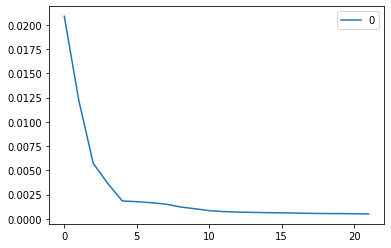

In [41]:
# Visual loss
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [47]:
df.columns

Index(['id', 'guidislink', 'link', 'updated', 'updated_parsed', 'published',
       'published_parsed', 'title', 'title_detail', 'summary',
       'summary_detail', 'authors', 'author_detail', 'author', 'links',
       'arxiv_primary_category', 'tags', 'arxiv_comment', 'arxiv_doi',
       'arxiv_journal_ref', 'arxiv_affiliation', 'tokens', 'tokens_merged'],
      dtype='object')

In [48]:
def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(df)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Title: ', df.iloc[index, 7])
        print('ID: ', df.iloc[index, 0])  
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

# add function to sort by percentage


In [51]:
# Specify how many 'outliers' you want to see
N = 20

In [52]:
print('Top n unique')

sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)

display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n = N)

Top n unique
Title:  DISCO: Comprehensive and Explainable Disinformation Detection
ID:  http://arxiv.org/abs/2203.04928v1
Cosine Sim Val : -0.06759274005889893
---------------------------------
Title:  GAN-generated Faces Detection: A Survey and New Perspectives (2022)
ID:  http://arxiv.org/abs/2202.07145v2
Cosine Sim Val : -0.05755409970879555
---------------------------------
Title:  Characterizing COVID-19 Misinformation Communities Using a Novel Twitter
  Dataset
ID:  http://arxiv.org/abs/2008.00791v4
Cosine Sim Val : -0.05403953790664673
---------------------------------
Title:  Cognitive Analysis of Security Threats on Social Networking Services:
  Slovakia in need of stronger action
ID:  http://arxiv.org/abs/2005.08618v1
Cosine Sim Val : -0.051104847341775894
---------------------------------
Title:  A Simulated Cyberattack on Twitter: Assessing Partisan Vulnerability to
  Spear Phishing and Disinformation ahead of the 2018 U.S. Midterm Elections
ID:  http://arxiv.org/abs/1811.0

### Visualizing the cosines - will revise during first test

/home/jesselehrke/Documents/GitHub/disinfo_radar_development/dr_venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

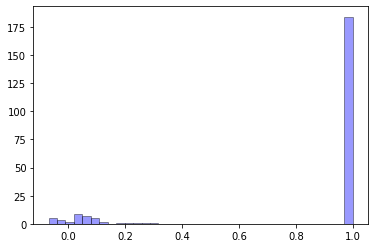

In [46]:
# Seaborn histogram
# Can use to adjust the N above (or percent, once we have that function) to see the low cluster

sns.distplot(losses, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

# # Add labels
# plt.title('Title')
# plt.xlabel('Label x')
# plt.ylabel('Label y')

### IIRC not fully functional yet - for more Cosine work

In [54]:
len(list(df.columns))

23

In [57]:
df.columns

Index(['id', 'guidislink', 'link', 'updated', 'updated_parsed', 'published',
       'published_parsed', 'title', 'title_detail', 'summary',
       'summary_detail', 'authors', 'author_detail', 'author', 'links',
       'arxiv_primary_category', 'tags', 'arxiv_comment', 'arxiv_doi',
       'arxiv_journal_ref', 'arxiv_affiliation', 'tokens', 'tokens_merged'],
      dtype='object')

In [60]:
most_unique_index, cosine_sim_val = sorted_cosine_similarities[0]
print(most_unique_index)
most_unique_plot =df.iloc[most_unique_index, 9] # index here matters!
most_unique_words_counter = Counter(preprocess_string(most_unique_plot))
print(most_unique_words_counter)

# intersected_common_word_counter = common_word_counter & most_unique_words_counter

# intersected_common_words = [word[0] for word in intersected_common_word_counter.items()]
# intersected_common_word_counts = [word[1] for word in intersected_common_word_counter.items()]

# intersected_common_word_counter

2
Counter({'disinform': 5, 'detect': 4, 'disco': 3, 'comprehens': 2, 'explain': 2, 'address': 2, 'demo': 2, 'refer': 1, 'fals': 1, 'inform': 1, 'deliber': 1, 'spread': 1, 'influenc': 1, 'gener': 1, 'public': 1, 'neg': 1, 'impact': 1, 'societi': 1, 'observ': 1, 'numer': 1, 'issu': 1, 'polit': 1, 'agenda': 1, 'manipul': 1, 'financi': 1, 'market': 1, 'paper': 1, 'identifi': 1, 'preval': 1, 'challeng': 1, 'advanc': 1, 'relat': 1, 'autom': 1, 'multipl': 1, 'aspect': 1, 'propos': 1, 'framework': 1, 'call': 1, 'leverag': 1, 'heterogen': 1, 'predict': 1, 'opaqu': 1, 'provid': 1, 'demonstr': 1, 'real': 1, 'world': 1, 'fake': 1, 'new': 1, 'task': 1, 'satisfactori': 1, 'accuraci': 1, 'explan': 1, 'video': 1, 'sourc': 1, 'code': 1, 'publicli': 1, 'avail': 1, 'expect': 1, 'pave': 1, 'wai': 1, 'limit': 1, 'identif': 1})
